# 11 - Exploration of Historical NBA Players (Part III, Principal Components Analysis)
From my last post:

> In the next post, I'll try to throw Principal Components Analysis at the problem because... well basically more or less because I want to learn it regardless of whether it applies here or not!

Do I need more of an intro? Let's go!

![](http://i.makeagif.com/media/9-28-2015/H8PLvc.gif)

(This has more or less become my favourite gif of all time...)

## Principal Components Analysis
So, simply put, PCA is a form of dimension reduction. This means that you can represent, let's say, 2 dimensions with 1. If you have the following data:

![](https://i.stack.imgur.com/lNHqt.gif)

You can see that the data is stretched out one way more than the other. Theoretically, most of the variace can be represented in the way in which the data is stretched the most. At the end of the animation, PCA has found the "axis" which represents the most variance, and if you project all those data points onto this axis in a perpendicular fashion, you'll **the** most accurate representation of the two dimension data in... abracadabra... **1 dimension**! You can move anywhere along that axis and it will give you an estimate of where both x and y are positioned in the 2D world.

The process above (although not mathetmatically accurate to what PCA is **ACTUALLY** doing behind the scenes) demonstrates how PCA finds that axis. The first principal component is basically the axis which exhibits the lowest error between the actual data point in 2D and the projection onto the axis in 1D. The axis that the PCA animation starts out with is almost perpendicular to the true principal component, so you see the distance away from the points and their projects on the axis are quite wide. As PCA finds the right axis, you see the cumulative error decrease to some optimal point.

Now, principal components analysis is not actually an interative method. That is, it doesn't start off on some random axis, and optimize in steps based on the error. It actually calculates it in one shot through a process called singular value decomposition. And here, we get quite deep into linaer algebra.

To learn this, I had to break out my old university textbooks... okay I lied, I had to do what we do in modern day learning... YouTube either until your heart and mind are content, or when you wake up for the 3rd time trying to get through 1 video, you know your days worth of studying is probably over. Eitiher way, the naps were more for fatigue, rather than lack of interest. It's actually quite fascinating how this calculation is done, and I do not regret going as deep as I went to find the right answers.

Now the real answer involves knowledge on multiple topics, but Singular Value Decomposition (SVD) goes something like this. 

#### 1.
Every data set is essentially a matrix. We're used to seeing 2D data sets because, again, we are human. Realistically, data sets could be whatever dimension matrix we want.

#### 2.
Every matrix can be represented as a vector transformation. I won't go in too deep, but this video explains it pretty well:
[![](http://img.youtube.com/vi/kYB8IZa5AuE/0.jpg)](http://www.youtube.com/watch?v=kYB8IZa5AuE)

How bad is it that I actually had **fun** and got **excited** watching this video? I'm not sure if I can actually publish this blog...

Essentially, each matrix can be seen as a **transformation** in vector space. For example, there exists a matrix that will actually apply this **transformation** to the following shape, or essentially infinite vectors that **make up this shape**.
![](http://www.solitaryroad.com/c149/ole4.gif)

#### 3.
Every transformation (matrix) can be decomposed down to three pieces:
1. Rotation
2. Stretch
3. Rotation

Something like this (from the SVD wiki page):
![](https://upload.wikimedia.org/wikipedia/commons/e/e9/Singular_value_decomposition.gif)

Therein lies the answer to our question. If we can backtrack through these steps and find out exactly where the stretch happened and that last rotation happened, **that essentially gives us our principal component!!!** Sorry, too excited there... Remember, this abstraction of the concept all came from the analogy that our data set is a **matrix transformation**. The best thing is that, again, this isn't an iterative process, it's actually just a few calculations and you get your decomposition.

![](https://media.giphy.com/media/5GoVLqeAOo6PK/giphy.gif)

---

As to not make this into a math blog per se, that's the concept behind how the SVD is calculated. I'll now skip to the analysis where I get to use SVD (honestly, I don't think I'd be able to explain the details of it here anyways... what's the opposite of a humble brag?).

Here, we're also just talking about SVD in a 2D context. We can find however many principal components there are to find up to the number of dimensions of the data set. This makes sense, because the principal component itself is a combination of any or all of the features. A 7D data set can have the principal component span all 7 dimensions. The rest of the principal components are then orthogonal to this one, and each subsequent one orthogonal to all the previous. Here is a better way to view this in 3 dimensions:
<img src = "https://i.stack.imgur.com/WgiUk.png" style = "width: 400px;"/>

Let's fire up SVD on those same variables we were looking at last time and check out some results.

In [162]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [341]:
%%R
# Load libraries & initial config
library(ggplot2)
library(gridExtra)
library(scales)

In [164]:
# Load libraries & initial config
%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [165]:
# Retrieve team stats from S3
playerAggDfToAnalyze = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfToAnalyze.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfToAnalyze.dtypes))
print playerAggDfToAnalyze.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [166]:
# Filter to remove outliers, player must have played over 10 minutes and in over 20 games on the season
playerAggDfToAnalyzeMin10Min20Games = playerAggDfToAnalyze[(playerAggDfToAnalyze['perGameStats_MP'] > 10) & (playerAggDfToAnalyze['perGameStats_G'] > 20)]

I'm kinda cheating here but I tried fitting a PCA model and it gave me an error, something about not being able to process NaNs or infinities. I don't know why there would be but there seems to be some NaNs in the data.

In [167]:
playerAggDfToAnalyzeMin10Min20Games[
    np.isnan(playerAggDfToAnalyzeMin10Min20Games['per100Stats_AST']) | np.isnan(playerAggDfToAnalyzeMin10Min20Games['per100Stats_FTPerc'])
][[
    'season_start_year',
    'perGameStats_Player',
    'per100Stats_AST',
    'per100Stats_FTPerc'
]]

,season_start_year,perGameStats_Player,per100Stats_AST,per100Stats_FTPerc
598,2010,Jason Williams,9.2,NaN
509,2011,Luke Walton,5.1,NaN
511,2011,Luke Walton,5.3,NaN


Mm... fair enough. These guys probably just never shot any free throws?

In [168]:
playerAggDfToAnalyzeMin10Min20Games[
    np.isnan(playerAggDfToAnalyzeMin10Min20Games['per100Stats_AST']) | np.isnan(playerAggDfToAnalyzeMin10Min20Games['per100Stats_FTPerc'])
][[
    'season_start_year',
    'perGameStats_Player',
    'per100Stats_AST',
    'per100Stats_FT',
    'per100Stats_FTA',
    'per100Stats_FTPerc'
]]

,season_start_year,perGameStats_Player,per100Stats_AST,per100Stats_FT,per100Stats_FTA,per100Stats_FTPerc
598,2010,Jason Williams,9.2,0.0,0.0,NaN
509,2011,Luke Walton,5.1,0.0,0.0,NaN
511,2011,Luke Walton,5.3,0.0,0.0,NaN


Correct, they did not shoot any free throws. When it comes to missing data, I've seen kinda two main ways to deal with it:
1. The magic word I hear is "impute", which essentially is filling in the missing data with... well... data
2. Remove those samples / observations

_**Imputation**_
---
Imputation means filling missing values with actual values. When I started in business analyst roles, I'd always be like, oh yeah, it's zero, whatever. But I'd generally be dealing with a metric like sales, where let's say your business was shut down that month and your accounting system recorded no sales, if you tried to group the sales by month, you'd get an "NaN" or equivalent because, well, there are no entries for that month! In this case, the value is zero, and this imputation is correct! Note that this is different from the case where you still had sales coming in but your accounting system was down that month. In this case, sales still came in, but your accounting system simply **doesn't know** what the value should be, so it will not guess. In this case, if I imputed the missing values with 0, I would be dead wrong, and would be skewing my data really badly.

This also depends on the type of calculation you're doing, and what problem you are trying to solve. If you're trying to calculate the sum of your sales, imputing a 0 for the missing month is no problem. No sales that month, nothing added, no harm no foul. If you're trying to calculate your average sales for the months (that you were in business), could you really impute a 0? 0 would incorrectly drag your average down. Again, it depends on the question you are trying to answer. Should that month drag your average down? I suppose if you were just looking at sales per month, maybe it should. But why were you out of business? What if it wasn't your fault, and you wanted to get a sense of your average sales within a context that you could control? That 0 will reflect poorly on your efforts, but in reality it was a freak accident that maybe we can omit. In this case, you could (and probably would) remove that month altogether from your observations (see next section), or you could fill it with the mean of the data without that observation. If you filled it with the mean, it wouldn't have any impact on your final results.

Depending on the context, the median, max, min, other benchmarks can be used as well.

_**Removing Observations**_
---
The other option is to simply remove that sample altogether and forget about it. It gets a bit tricky when figuring out which to use in certain situations. Removing an observation means you are **decreasing your sample size**, and that's the key question we must answer. Can you afford to decrease your sample size such that your sample is still statistically accurate? Can you be confident of your results if you have a sample of 100, and 50 of them have missing values? What if you only have one feature that's missing values, but data is populated for all the other features? These are all fair questions depending on context, but it seems that, if you can afford to lose a few samples, then removing observations is probably your best bet. Removing observations makes no assumptions about the data, whereas imputing does. We're not assigning an estimated value to anything, we're simply saying we don't know this value, let's not even worry about it in the calculation.

In our case, we have what... 15000+ samples? The two Luke Waltons and the one Jason Williams makes up 3 samples, I think we can afford to just drop them.

In [169]:
# Load PCA model
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)

# Try PCA on just 2 predictors
pca.fit(playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna())

# Check the principal components
print 'The two principal components communicate the following variances: {}'.format(pca.explained_variance_ratio_)
print 'The first principal component, made up of Assists and FT%, have the following weights respectively: {}'.format(pca.components_[0])

The two principal components communicate the following variances: [ 0.99888355  0.00111645]
The first principal component, made up of Assists and FT%, have the following weights respectively: [-0.99994292 -0.01068413]


I just found the first two (and only two...) principal components within this data set. There are only 2 principal components because there are only 2 predictors! What this is essentially telling me is that 99.9% of the variance can be explained in the first principal component.

The first principal component is

$$-0.9999\times Assists - 0.0107\times FT\%$$

Does this sound right? This is essentially saying FT% doesn't matter in the grand scheme of things, essentially assists will capture all of the variance and FT% doesn't have any variance.

Let's plot the two just to check out the relationship again.

<IPython.core.display.Javascript object>


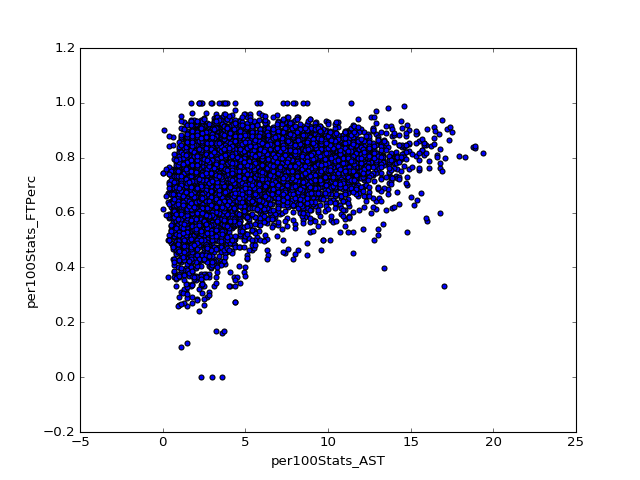

In [170]:
playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna().plot(kind = 'scatter', x = 'per100Stats_AST', y = 'per100Stats_FTPerc')

I mean, there definitely looks like there's variance there, any way you dice it.

Ok, looking at the formula again, I see why it's so lopsided. The **absolute value** of variance in assists is **wayyyyyyyyyy more** than the absolute value of variance for FT%. This is looking like a 5 assist difference equals roughly 20% (or more importantly, 0.2) FT% difference... The values need to be **SCALED** first. Good thing I did a test with 2 variables...

In [171]:
from sklearn.preprocessing import scale

print '---Original data---'
print playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna().head(10)

print '\n'

# Normalize df
print '---Scaled data---'
print scale(playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna())[:10]

---Original data---
    per100Stats_AST  per100Stats_FTPerc
0               5.4               0.765
1               3.4               0.683
2               6.8               0.797
3              11.0               0.830
4               3.4               0.640
6               1.8               0.673
7               3.1               0.753
8               5.5               0.665
10              7.0               0.935
16              4.4               0.702


---Scaled data---
[[ 0.27856313  0.22264   ]
 [-0.38672461 -0.55452299]
 [ 0.74426455  0.52592312]
 [ 2.14136882  0.83868383]
 [-0.38672461 -0.96205968]
 [-0.91895481 -0.64929896]
 [-0.48651778  0.10890883]
 [ 0.31182752 -0.72511974]
 [ 0.81079333  1.83383156]
 [-0.05408074 -0.37444864]]


Hmm, it seems that the scale() function returns a list of lists instead of a dataframe. Not what I expected, but I guess the values make sense in general.

It also looks like the data scaled to mean-zero and standard deviations. If I go down the list and just look at the first few values, I would imagine
- AST: Mean 4, STD 3.5
- FT%: Mean 70%, STD 11%

Let's see...

In [172]:
playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna().describe().loc[['mean', 'std']]

,per100Stats_AST,per100Stats_FTPerc
mean,4.562578,0.741509
std,3.006332,0.105516


Close enough! You know, I am a bit concerned that I was supposed to scale to, I wanna call, unit scale? I'm not quite sure what it's called but basically the values are summarized to between 0 - 1. Upon some quick googline though, it makes sense because, well, I guess depending on how you do it, you're essentially just standardizing the **variance** for each parameter. Whether it be constrained between 0 to 1, or variance is translate to unit variance, the important thing is that the **variance** of both parameters are measured **on the same scale**.

Let's try PCA again:

In [173]:
n_components = 2

# Initialize PCA model
pca = PCA(n_components)

# Try PCA on just 2 predictors
playerAggListToAnalyzePCAResult = pca.fit_transform(scale(playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna()))

# Check the principal components
print 'The two principal components communicate the following variances: {}'.format(pca.explained_variance_ratio_)
print 'The first principal component, made up of Assists and FT%, have the following weights respectively: {}'.format(pca.components_[0])
print 'The second principal component, made up of Assists and FT%, have the following weights respectively: {}'.format(pca.components_[1])

The two principal components communicate the following variances: [ 0.6520432  0.3479568]
The first principal component, made up of Assists and FT%, have the following weights respectively: [-0.70710678 -0.70710678]
The second principal component, made up of Assists and FT%, have the following weights respectively: [-0.70710678  0.70710678]


This looks much better. I can already tell there should be a principal component in a uniformly linear fashion. A principal component isn't a vector, so by nature, it doesn't have a "direction". Our principal component is described with two coefficients for each variable, so we get the following for the two principal components

First principal component

$$-0.707\times Assists - 0.707\times FT\%$$

Second principal component

$$-0.707\times Assists + 0.707\times FT\%$$

Inherently, these kind of read like a vector, but I think PCA simply just has to choose some vector that represents the principal component.

We'll see this principal a bit better on the biplot. A biplot essentially maps both the sample data and the vectors of original features translated to this 2-dimensional space. A biplot implies that we are only looking at the first two principal components as, again, 3D is a bit more complex and 4D is impossible to visualize on a plot for us.

I've searched far and wide (spent about 20 minutes on Google) for a convenient biplot function in python. Couldn't find it. I'm going to try R instead. Unfortunately, I have to refit the entire PCA model, but luckily I work in the world of code where things can be done with a few typed letters and about 5 seconds time.

In [260]:
# Prepare dataframe to be passed to R
twoVarPCA = playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_AST',
    'per100Stats_FTPerc'
]].dropna()

In [261]:
%%R -i twoVarPCA

# Fit PCA model
pca = prcomp(twoVarPCA, center = T, scale = T)

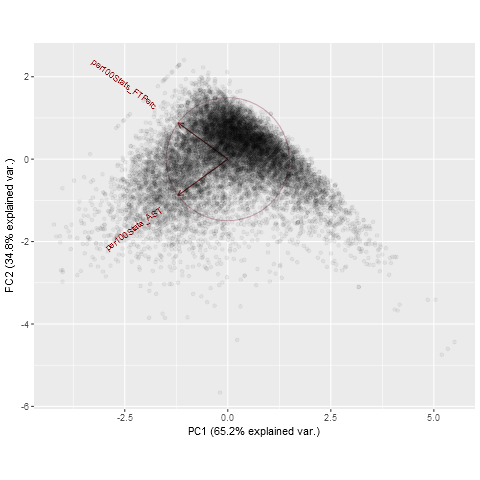

In [262]:
%%R
library(ggbiplot)

# Visualize biplot of PCA results
ggbiplot(pca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

That was easy. The ggbiplot function simply takes the pca model object and maps what seems to be a scatterplot and vectors of the features (we only looked at AST and FT% in this case) as represented in the 2D space by the direction and magnitude of their loadings.

With two dimensions, we can really get a sense of what PCA is actually doing. We see, along the first principal component is the axis where there is a linear relationship between the two variables.

Another representation of PCA I'd like to explore is what's called a scree plot.

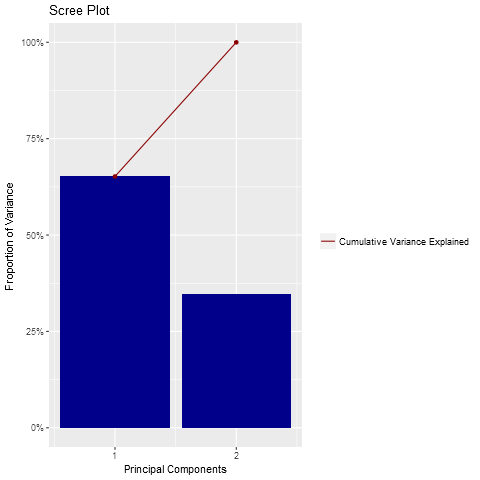

In [533]:
%%R

visScreePlot = function(pcaModel){
    # Prepare dataframe, a few steps here all mangled into one line
    #   1. Get only the "Proportion of Varaince" and "Cumulative Proportion" results out of summary(pca)$importance (2nd and 3rd rows of this matrix)
    #   2. Transpose the matrix so the column labels are the "Proportion of Variance" and "Cumulative Proportion" metrics
    #   3. Convert this matrix into a dataframe with the data.frame() command
    pcaMetricsDf = data.frame(t(summary(pcaModel)$importance[2:3,]))
    
    # By default, the prcomp function provides indexes "PC1", "PC2"... etc, I create another column "Principal.Component"
    #   with just an integer value "1", "2"... etc for sorting purposes when I output the scree plot...
    #   The axis with the principal components by default sorts "P10" and "P11" before "P2"
    pcaMetricsDf['Principal.Component'] = as.numeric(gsub('PC', '', row.names(pcaMetricsDf)))
    
    # Plot the "Proportion of Variance" (Bar) and "Cumulative Proportions" (Line) graphs to make up the scree plot
    ggplot(
        pcaMetricsDf
    ) +
    # Bar graph for proportion of variance explained
    geom_bar(
        aes(
            x = Principal.Component,
            y = Proportion.of.Variance
        ),
        stat = 'identity',
        fill = 'blue4'
    ) +
    # Line graph for cumulative proportion of variance explained
    geom_point(
        aes(
            x = Principal.Component,
            y = Cumulative.Proportion
        ),
        color = 'red4'
    ) +
    geom_line(
        aes(
            x = Principal.Component,
            y = Cumulative.Proportion,
            group = 1,       # Somehow must define group becase our X axis is a factor
            lty = 'Cumulative Variance Explained'
        ),
        color = 'red4'
    ) +
    # Because our x-axis (Principal Components) is an int, I standardize it to only show integers here, not 2.5... etc
    scale_x_continuous('Principal Components', breaks = seq(min(pcaMetricsDf$Principal.Component), max(pcaMetricsDf$Principal.Component), 1)) +
    # Format y-axis as percent
    scale_y_continuous('Proportion of Variance', labels = percent) +
    # Remove arbitrary title in the legend
    scale_linetype('') +
    ggtitle('Scree Plot')
}

visScreePlot(pca)

Along with the biplot, the scree plot shows us the proportion of all the variance that can be explained within each principal component.

## Statistical Sidenote...
Here, again, we are only looking at 2 dimensions, so you can only find two vector directions maximum that will explain 100% of the variance. If your two features are 100% correlated, that is let's say there's a formula

$$y=mx+b$$

that explains the relationship between your x and y, then theoretically we should see a scree plot with 100% variance explained in the first PC, and 0% in the second PC.

You know what... Let's just try that for a sec.

In [349]:
# Create dummy data
x = np.arange(1,6)
y = np.arange(1,6)
y[4] = y[4] + 1

# Transform to data frame
testPcaDf = pd.DataFrame({
    'x_var': x,
    'y_var': y
})

# Show data frame
testPcaDf

,x_var,y_var
0,1,1
1,2,2
2,3,3
3,4,4
4,5,6


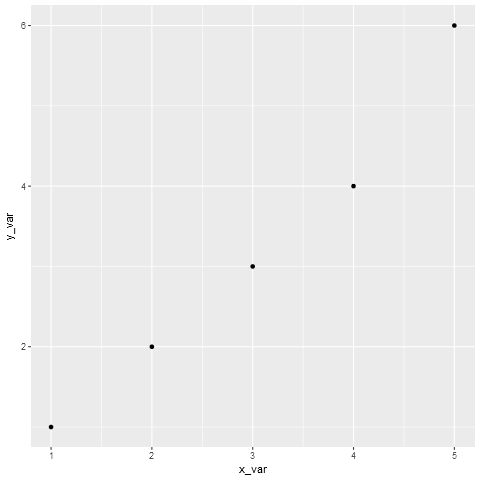

In [347]:
%%R -i testPcaDf

# Quick plot to show the points
qplot(data = testPcaDf, x = x_var, y = y_var)

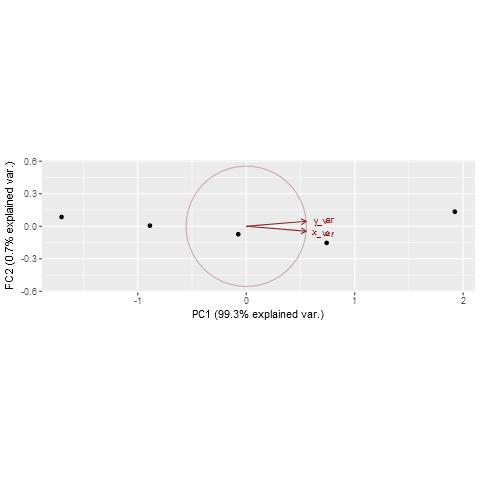

In [366]:
%%R -i testPcaDf

# Fit PCA model
testPca = prcomp(testPcaDf, center = T, scale = T)
ggbiplot(testPca, obs.scale = 1, var.scale = 1, circle = TRUE)

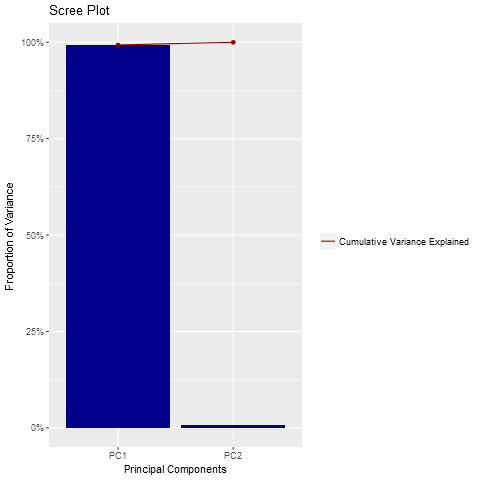

In [381]:
%%R

visScreePlot(testPca)

This puts things in a bit more perspective. In both cases (our AST vs FT% graph, and our dummy data), we are dealing with two features so we can visually see which direction has the greatest variance. In the second case, however, it's extremely clear that the variance can be boiled down to essentially 1 axis, because lo-and-behold, we created the data to be exactly like that.

We can see that x and y both contribute equally to the first and second principal component, but they both contribute wayyyyyyyyyyyyy more heavily to the first principal component as the first PC expalined >99% of the variance!

## Back To Basketball...
Awesome, I've educated myself a bit more on PCA and exactly what it's calculating and what I should be taking away from it. My first impression is to just throw all the features at it and see what happens... Whether this is scientifically or statistically or just downright rationally logical is up to a future me who knows and understands this information, but this is what present me wants to do and damn it I do what I want to do.

![](http://www.prcouture.com/wp-content/uploads/2016/07/Exude-confidence.gif)

Okay, I'm not going to put EVERY single feature in, I'll take a look at a few things that may make sense.

In [563]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPcaFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'per100Stats_FGA',
    'per100Stats_FGPerc',
    'per100Stats_3PA',
    'per100Stats_3PPerc',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS'
]]

print 'There are {} rows of data'.format(playerAggDfToAnalyzeMin10Min20GamesPcaFeatures.shape[0])

There are 13220 rows of data


In [564]:
# Check for na values in each column
for column in playerAggDfToAnalyzeMin10Min20GamesPcaFeatures.columns:
    print 'there are {} na values in the column {}'.format(
        len(playerAggDfToAnalyzeMin10Min20GamesPcaFeatures[pd.isnull(playerAggDfToAnalyzeMin10Min20GamesPcaFeatures[column])]),
        column
    )

there are 0 na values in the column per100Stats_FGA
there are 0 na values in the column per100Stats_FGPerc
there are 0 na values in the column per100Stats_3PA
there are 1344 na values in the column per100Stats_3PPerc
there are 0 na values in the column per100Stats_2PA
there are 0 na values in the column per100Stats_2PPerc
there are 0 na values in the column per100Stats_FTA
there are 3 na values in the column per100Stats_FTPerc
there are 0 na values in the column per100Stats_ORB
there are 0 na values in the column per100Stats_DRB
there are 0 na values in the column per100Stats_AST
there are 0 na values in the column per100Stats_STL
there are 0 na values in the column per100Stats_BLK
there are 0 na values in the column per100Stats_TOV
there are 0 na values in the column per100Stats_PF
there are 0 na values in the column per100Stats_PTS


Hmm, there are actually 1344 NA values in 3 point percentage. I would imagine that these are players who didn't actually shoot any 3's throughout the season. Given how we've seen 3P shooting develop, I wouldn't imagine if there were players in the 80's who didn't even attempt a single 3, or even centers today who never attempt 3's (does that breed exist anymore? I won't bother your time checking... but off the top of my head I feel like someone like Robin Lopez never shoots 3's).

Here we cross paths with imputation again. Do we impute? Drop? Let's think about this logically... I would just assume that most of these are centers since any guard or forward that played in a decent amount of games for decent minutes (modern day) would probably launch up a 3 at some point, even 1 in the season will register a %.

In [409]:
playerAggDfToAnalyzeMin10Min20Games[
    np.isnan(playerAggDfToAnalyzeMin10Min20Games['per100Stats_3PPerc'])
][
    'perGameStats_Pos'
].value_counts()

C        846
PF       397
SF        71
SG        14
C-PF       5
PG         5
PF-C       4
SF-PF      1
SG-PG      1
Name: perGameStats_Pos, dtype: int64

Okay, so most of these are centers / PFs, as I would have guessed. Now we have come to some sort of crossroads. My first instinct is to not throw away these rows of data because there are ~1300 of them out of ~13000, that's 10% of our data! That's a little too much.

My second instinct is to just make them 0%. If a center doesn't shoot 3's, it's probably because they can't shoot, period. Again, I don't want to generalize why ~1300 players throughout history didn't shoot 3's, but if they're a center, it's probably cause they couldn't shoot 3's, or their jobs weren't to. I really don't know if C's back in the day practiced 3's. I would imagine not, and in a game situation, I'd assume they wouldn't make 3's at a great rate. I can already think of situations where a center was forced to shoot a 3 one time in his career due to a shot clock expiring or something, and they happen to make it, and for that season they sat at 100% for 3. Then a guard that shoots 40% on 3's while taking 200 shots on the season all of a sudden bows down before this C with 100% 3P. You know what, I think I'm just going to take out percentages from my features altogether. There are too many assumptions I'm making with imputing to 0%.

In [565]:
# Select subset of features
playerAggDfToAnalyzeMin10Min20GamesPcaFeatures = playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'per100Stats_FGA',
    'per100Stats_3PA',
    'per100Stats_2PA',
    'per100Stats_2PPerc',
    'per100Stats_FTA',
    'per100Stats_FTPerc',
    'per100Stats_ORB',
    'per100Stats_DRB',
    'per100Stats_AST',
    'per100Stats_STL',
    'per100Stats_BLK',
    'per100Stats_TOV',
    'per100Stats_PF',
    'per100Stats_PTS'
]].dropna()

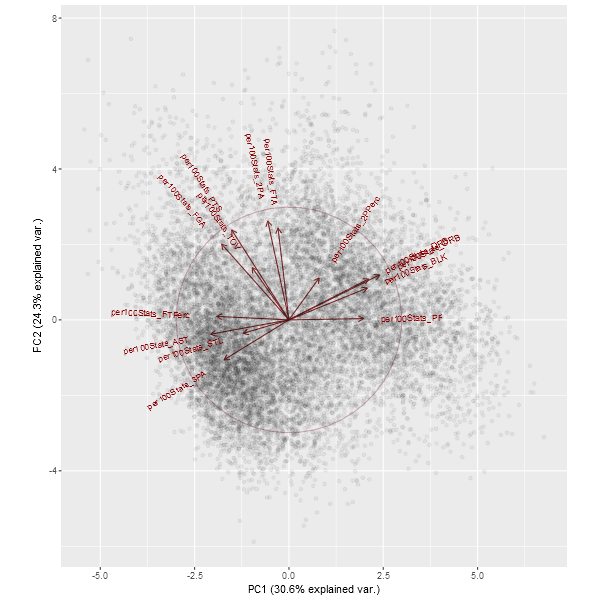

In [572]:
%%R -i playerAggDfToAnalyzeMin10Min20GamesPcaFeatures -w 600 -h 600 -u px

playerAggDfToAnalyzeMin10Min20GamesPcaFeaturesLabels = playerAggDfToAnalyzeMin10Min20GamesPcaFeatures$perGameStats_Pos
playerAggDfToAnalyzeMin10Min20GamesPcaFeaturesData = playerAggDfToAnalyzeMin10Min20GamesPcaFeatures[ , !(names(playerAggDfToAnalyzeMin10Min20GamesPcaFeatures) %in% c('perGameStats_Pos'))]

# Fit PCA model
moreFeaturesPca = prcomp(playerAggDfToAnalyzeMin10Min20GamesPcaFeaturesData, center = T, scale = T)
ggbiplot(moreFeaturesPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.05)

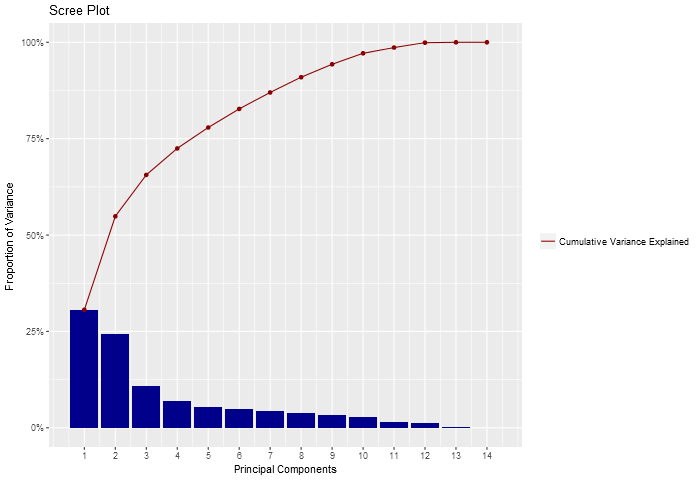

In [534]:
%%R -w 700 -u px

visScreePlot(moreFeaturesPca)

Alright, so how useful is this... Not really to be honest. Many ideas are jumping at me right now. Let me feed the fire a little bit in no particular order
- Variances are takes a few dimensions to explain, if PCA were to dimension reduce like a charm, I think we would see
    - In the bi-plot, all the vectors as horizontal vectors along the x-axis
    - In the scree plot, much higher than 30% variance for the first PC (well, okay, truth be told, I don't know if 30% is good in practice... I simply don't have the experience in various use cases yet)
- The first two PC's combine for over **50% variance**, that's not horrible considering we started with 14 features!
- On the bi-plot, along the first PC, we see 2 features that are right on it, and a few that are nearby the x-axis
    - In one direction, we see **FT%, AST, STL, 3PA**
    - In the other direction, we see **DRB, ORB, BLK, PF**
- On the bi-plot, on the same axis as these opposing features, we see two "clusters" of points on the scatterplot in the background
    - To me, these correlate to traditional "Guards / Wings" and traditional "Forwards / Big Men"
        - In the direction of FT%, AST, STL, 3PA, I would imagine Guards to have more of these
        - In the direction of DRB, ORB, BLK, PF, I would imagine Forwards to have more of these (well, big men get more fouls? I didn't know that... but we can find out)
- The bi-plot also tells me that the first principal component was chosen in the direction of FT% and PF with contributions from other features (FT% seems to be inversely proportional to PF?)

I'm not quite sure I believe FT% is inversely proportional to PF, I'm just going to plot this real quick to check it out:

<IPython.core.display.Javascript object>


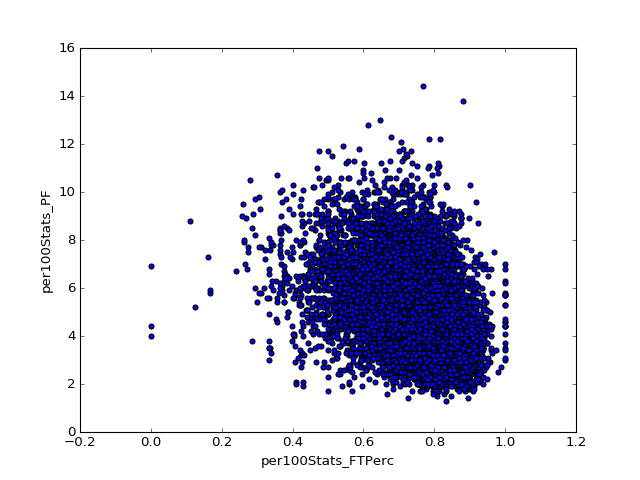

In [536]:
playerAggDfToAnalyzeMin10Min20GamesPcaFeatures.plot(kind = 'scatter', x = 'per100Stats_FTPerc', y = 'per100Stats_PF')

This isn't too linear of a relationship, but I suppose, out of all the non-linear relationships, this specific axis demonstrates the most variance compared to others. I can accept that, I guess, and if I somehow did something wrong, it better come back to bite me in the ass later.

I also want to check the data point that big men have more fouls...

<IPython.core.display.Javascript object>


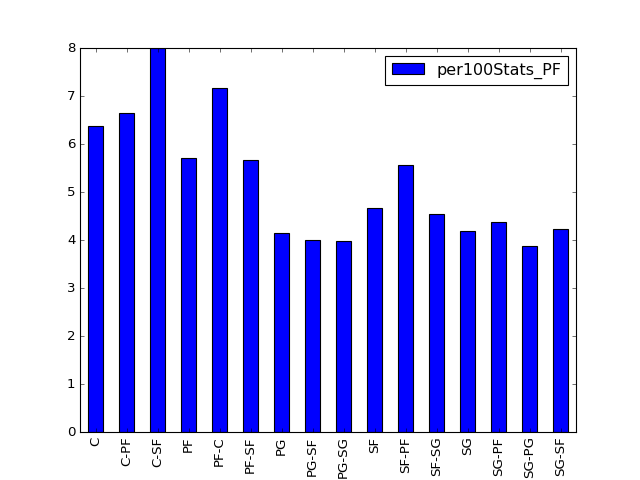

In [547]:
playerAggDfToAnalyzeMin10Min20Games[[
    'perGameStats_Pos',
    'per100Stats_PF'
]].dropna().groupby(
    'perGameStats_Pos'
).agg({
    'per100Stats_PF': np.mean
}).reset_index().plot(kind = 'bar', x = 'perGameStats_Pos', y = 'per100Stats_PF')b

Well, there you go. If I didn't learn anything today, I learned that big men foul more per 100 possessions. Not sure why this is. Perhaps big men get switched out more frequently and they can afford to foul more per possession becuse they're playing less per game, but I don't know, guards are running around the floor, however I can definitely remember situations where I was forced to guard someone way larger than me and that tired me out way more than running around the floor trying to lose my man.

I just noticed that ggbiplot let's us also color the scatterplot by groups. So I can actually confirm some of these guard vs big men thoughts running around in my head.

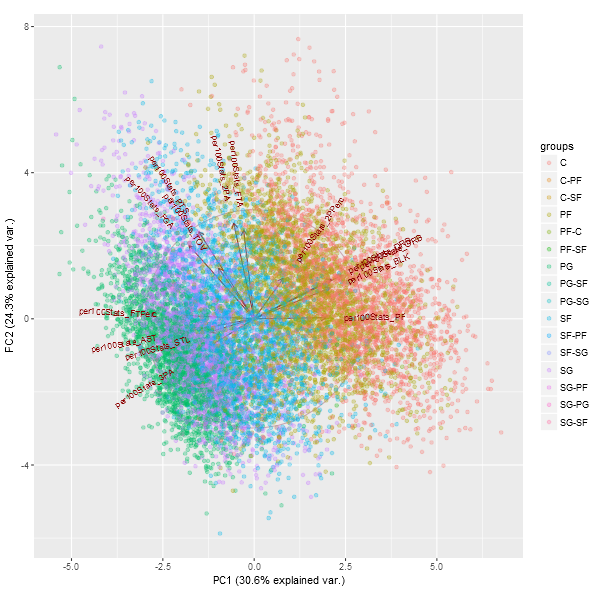

In [573]:
%%R -w 600 -h 600 -u px

ggbiplot(moreFeaturesPca, obs.scale = 1, var.scale = 1, circle = TRUE, alpha = 0.3, groups = playerAggDfToAnalyzeMin10Min20GamesPcaFeaturesLabels)

That's a beauty man... That's insane that I can even look at a graph that gives me so much information. I'm probably caught up in the colors but, honestly, it really does make sense on first glance.

We see a clear divide between P, SG, SF, PF, C. The hyphenated positions like C-PF etc... kind of fall into place with the colors - PG is a bit out of place but it all seems to work.

Your PG and SG's fall towards the FT% / AST / STL / 3PA end of the spectrum.

Your PF and C's fall towards the DRB / ORB / BLK / PF end of the spectrum.

Your SF's are smack dab in the middle and seem to span both realms. I think we can see how the game is changing by looking at the PF / C side. If I take a look at red dots, they bleed into the SF part of the spectrum. PF's have kind of the same story, there is a large range they span, and they even go into the SG portion.

Your PG's are pretty tightly bound to their end of the spectrum. SG's are also pretty tightly bound compared to your C's and PF's.

Those features orthogonal to the guards / big men axis I guess don't seem too surprising but they are just interesting to see. PTS / TOV / FGA lean slightly towards the guards and 2PA / FTA lean slightly towards big men. 2P% lean largely towards big men and this is understandable.

It would be interesting to see how this graph changes throughout the decades.

## Phew...
This one was a long one. Some ideas I have that I will likely fulfill in the next few posts:

### Dimension Reduction
I want to look at at least one more dimension reduction method. I saw the use of an isomap in a presentation once and I just thought it was the coolest thing ever. I'm not quite sure if it's the same thing as PCA, I remember seeing a 2D representation of a multidimensional data set, but perhaps the presenter used enough colors that I was just drawn to the resulting graphs haha...

![](https://2.bp.blogspot.com/-k_C39Ul0I5M/VYFw1ixbFbI/AAAAAAAAiYo/D6RRV357NuQ/s1600/discokugelani-1.gif)

### Clustering
The fact that the guards and the big men are somewhat clustered out like that is really interesting to me. I would love to explore that a bit further and maybe even apply a clustering algorithm in this two dimensional space, we can basically classify if a player's statline looks more like that of a guard of big man. Is this useful? I don't think so, I don't think we'd ever see a player's statline without knowing who it is or which position they play, but it's interesting that the data can be broken down in such a direct manner within only two steps (PCA --> Clustering)!

I can defend this all I want but at the end of the day I just want to try clustering haha.

Okay but seriously, I feel that this is a one two punch that is often performed in data analysis. You have a data set that you don't know much about. You bring it down to a number of dimensions that you can visualize and digest as a human, you see if there's an opportunity to cluster. I could see this happening in any case where you have a large number of features and you're trying to group the data in to different buckets. Market segmentation is a good example where you've got all these different traits of customers who, let's say, have specific shopping patterns whether it be time of day, things they bought, time taken... etc and you could identify these customers with grouped habits and market to them in different ways.

Again, in our case here, we **already know what positions the players play**, we don't need to explore and "predict" what groups they belong to, but it is reaffirming to know that Guards have higher FT%, AST, STL, and 3PA and that big men have more... PF? I guess!